In [ ]:
from generator import UniformCNFGenerator
import utils
import train

import numpy as np
import matplotlib.pyplot as plt

## Example 1

Create random sat formula and check if a random assignment satisfies the formula. 

In [ ]:
# Create a sat generator
sat_gen = UniformCNFGenerator(min_n = 5,
                              max_n = 5,
                              min_k = 3,
                              max_k = 3,
                              min_r = 4.2,
                              max_r = 4.2)

In [ ]:
# Create a random sat formula
n, r, m, formula = sat_gen.generate_formula()

print(f'n: {n}')
print(f'r: {r}')
print(f'm: {m}')
print(formula)

In [ ]:
# Create a random assignment
assignment = utils.random_assignment(n=n)

print(assignment)

In [ ]:
# Verifying whether the assinment satisfied the formula
is_sat, num_sat, eval_formula = utils.assignment_verifier(formula, assignment)

print(f'assignment sats the formula: {is_sat}')
print(f'num of sat clauses: {num_sat} out of {m}')

## Example 2

Load a sat formula from the SATLIB dataset and check if a random assignment satisfies the formula.

SATLIB: https://www.cs.ubc.ca/~hoos/SATLIB/benchm.html

In [ ]:
dimacs_path =  'data/uf20-91/uf20-01.cnf'
n, m, formula = utils.dimacs2list(dimacs_path = dimacs_path)

print(f'n: {n}')
print(f'm: {m}')
print(formula)

In [ ]:
assignment = utils.random_assignment(n=n)

print(assignment)

In [ ]:
is_sat, num_sat, eval_formula = utils.assignment_verifier(formula, assignment)

print(f'assignment sats the formula: {is_sat}')
print(f'num of sat clauses: {num_sat} out of {m}')

## Example 3

Using a basicRNN solver

n = 5

r = 2

m = (5*2) = 5

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions
import torch.optim as optim

from architectures import BasicRNN

def train(X):    
    action_log_probs = []
    actions = []

    #1. X = [[x0, x1, ..., xn]]
    #X: [batch_size=1, seq_len]
    X = X.permute(1, 0).unsqueeze(-1)
    #X: [seq_len=n, batch_size=1]

    a_prev = torch.tensor(2).reshape(1,1) #2 means no a_prev
    #a_prev:[batch_size=1, seq_len=1]

    state = policy_network.init_state_basicrnn()
    #state: [num_layers, batch_size, hidden_size]

    for t, x in enumerate(X):
        #x: [seq_len=1, batch_size=1]
        x = x.permute(1, 0)
        #x: [batch_size=1, seq_len=1]

        input_t = (x, a_prev)
        #2. Action logits
        action_logits, state = policy_network((input_t), state)

        #3. Prob distribution over actions
        action_dist = F.softmax(action_logits, dim = -1)
        #4. Sample an action        
        dist = distributions.Categorical(action_dist)
        action = dist.sample()
        #5. Log-prob of the action
        action_log_prob = dist.log_prob(action)
        #6. Take the choosen action
        #-------
        #7 Store actions and action_log_prob
        action_log_probs.append(action_log_prob)
        actions.append(action.item())

        a_prev = action
    
    #Compute H: num of sat clauses
    is_sat, num_sat, _ = utils.assignment_verifier(formula, assignment=actions)
    H = torch.tensor(num_sat).detach()


    #Update parameters
    action_log_probs = torch.cat(action_log_probs)
    loss = - (H * action_log_probs.sum())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    return loss, H, actions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions
import torch.optim as optim

from architectures import BasicRNN

def train(accumulation_steps, formula, num_episodes, clip_val=None):
    
    history_loss = []
    history_H = []

    mean_loss = 0
    mean_H = 0

    policy_network.train()
    optimizer.zero_grad()
    for episode in range(num_episodes):

        X = torch.tensor([[i for i in range(input_size)]])
        
        action_log_probs = []
        actions = []
        actions_logits = [] #for debugging***********************
        actions_dist = []

        #1. X = [[x0, x1, ..., xn]]
        #X: [batch_size=1, seq_len]
        X = X.permute(1, 0).unsqueeze(-1)
        #X: [seq_len, batch_size=1]

        a_prev = torch.tensor(2).reshape(1,1) #2 means no a_prev
        #a_prev:[batch_size=1, seq_len=1]

        state = policy_network.init_state_basicrnn()
        #state: [num_layers, batch_size, hidden_size]

        for t, x in enumerate(X):
            #x: [seq_len=1, batch_size=1]
            x = x.permute(1, 0)
            #x: [batch_size=1, seq_len=1]

            input_t = (x, a_prev)
            #2. Action logits
            action_logits, state = policy_network((input_t), state)

            #3. Prob distribution over actions
            action_dist = F.softmax(action_logits, dim = -1)
            #4. Sample an action        
            dist = distributions.Categorical(action_dist)
            action = dist.sample()
            #5. Log-prob of the action
            action_log_prob = dist.log_prob(action)
            #6. Take the choosen action
            #-------
            #7 Store actions and action_log_prob
            action_log_probs.append(action_log_prob)
            actions.append(action.item())
            actions_dist.append(list(np.around(action_dist.detach().numpy().flatten(), 2)))
            actions_logits.append(list(np.around(action_logits.detach().numpy().flatten(), 2))) #for debugging****************
            
            a_prev = action
    
        #Compute H: num of sat clauses
        is_sat, num_sat, _ = utils.assignment_verifier(formula, assignment=actions)
        H = torch.tensor(num_sat).detach()
        
        #Update parameters
        action_log_probs = torch.cat(action_log_probs)
        loss = -(H * action_log_probs.sum())

        #Gradient accumulation
        loss = loss / accumulation_steps
        H = H / accumulation_steps
        loss.backward()
        mean_loss += loss.item()
        mean_H += H
        if (episode + 1) % accumulation_steps == 0:
            if clip_val is not None:
                nn.utils.clip_grad_norm_(policy_network.parameters(), clip_val) 
            optimizer.step()
            optimizer.zero_grad()
        
            #Trackers
            history_loss.append(mean_loss)
            history_H.append(mean_H)
        
            print('Episode [{}/{}], Loss {:.4f}, H {:.4f}, Actions {}, Actions logits {}' 
                    .format(episode+1, num_episodes, mean_loss, mean_H, actions, actions_logits))
            
            mean_loss = 0
            mean_H = 0
        assignment = np.argmax(actions_dist, axis=1)
    return assignment, history_loss, history_H

# Experimento main

In [13]:
from generator import UniformCNFGenerator

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from architectures import BasicRNN
from architectures import BaselineRollout
from generator import UniformCNFGenerator
import utils
import train

#n:5
#r:4.2
#m:21
formula = [[-1, 2, 4], [-3, 5, -4], [2, -5, 1], [5, 3, 2], [5, -1, -2], [4, -3, 2], [3, 5, 2], [1, 5, -4], [1, -2, -4], [-3, 5, 2], [1, 2, 3], [-2, 5, -4], [-1, -3, 4], [3, -5, 4], [1, 5, -2], [-3, -5, -1], [5, 3, 2], [-5, -2, 3], [-5, 3, 2], [-3, -2, -1], [4, -5, 2]]

In [14]:
input_size = n #num of variables
embedding_size = 32
hidden_size = 128
output_size = 2 #Two assignments: 0 or 1
num_layers = 1

accumulation_steps = 5
num_episodes = 3000
clip_val = 1

num_rollouts = 2
sampled = True

policy_network = BasicRNN(input_size, embedding_size, hidden_size, output_size, num_layers)

baseline = BaselineRollout(num_rollouts, sampled)

lr = 0.001
optimizer = optim.Adam(policy_network.parameters(), lr=lr)

history_loss, history_H = train.train(accumulation_steps, formula, input_size, num_episodes, policy_network, optimizer, baseline, clip_val)

Episode [5/3000], Loss 1.4126, H 19.4000, Actions [0, 1, 1, 0, 0], Actions logits [[0.02, 0.0], [0.04, 0.04], [0.12, 0.01], [0.08, 0.05], [0.03, 0.03]]
Episode [10/3000], Loss -1.4554, H 18.6000, Actions [1, 1, 1, 0, 0], Actions logits [[-0.02, 0.05], [-0.0, 0.13], [0.07, 0.1], [0.02, 0.13], [-0.06, 0.14]]
Episode [15/3000], Loss -0.6975, H 18.8000, Actions [1, 0, 1, 1, 0], Actions logits [[-0.05, 0.09], [-0.06, 0.2], [-0.05, 0.2], [-0.09, 0.25], [-0.13, 0.26]]
Episode [20/3000], Loss -1.1704, H 18.6000, Actions [1, 0, 0, 1, 1], Actions logits [[-0.07, 0.12], [-0.1, 0.25], [-0.1, 0.26], [-0.19, 0.33], [-0.23, 0.35]]
Episode [25/3000], Loss 0.3832, H 19.2000, Actions [1, 1, 1, 1, 1], Actions logits [[-0.08, 0.13], [-0.1, 0.25], [-0.05, 0.25], [-0.11, 0.3], [-0.2, 0.35]]
Episode [30/3000], Loss -2.3381, H 18.4000, Actions [0, 0, 1, 1, 0], Actions logits [[-0.09, 0.14], [-0.18, 0.3], [-0.17, 0.33], [-0.2, 0.37], [-0.27, 0.43]]
Episode [35/3000], Loss -0.5552, H 19.0000, Actions [0, 1, 0, 

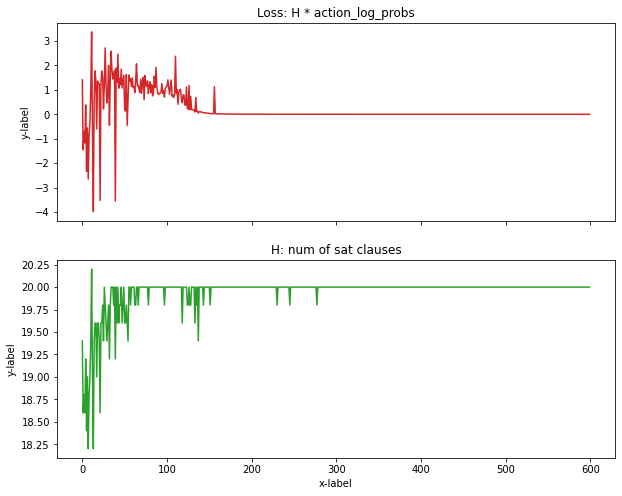

In [15]:
fig, axs = plt.subplots(2, 1,  figsize=(10,8))
axs[0].plot(history_loss, 'tab:red')
axs[0].set_title('Loss: H * action_log_probs')

axs[1].plot(history_H, 'tab:green')
axs[1].set_title('H: num of sat clauses')


for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Experimento 2

In [49]:
from generator import UniformCNFGenerator

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from architectures import BasicRNN
from architectures import BaselineRollout
from generator import UniformCNFGenerator
import utils
import train

#Create a sat generator
sat_gen = UniformCNFGenerator(min_n = 40,
                              max_n = 40,
                              min_k = 3,
                              max_k = 3,
                              min_r = 4,
                              max_r = 4)

#Create a random sat formula
n, r, m, formula = sat_gen.generate_formula()

print(f'n: {n}')
print(f'r: {r}')
print(f'm: {m}')
print(formula)

n: 40
r: 4.0
m: 160
[[-3, 23, -29], [-28, 14, 15], [-34, 37, 35], [-34, -32, -40], [-34, -38, -21], [-20, 10, 2], [-8, -33, -14], [-2, -13, 26], [17, 11, 12], [-24, 27, 20], [8, -34, -29], [39, 10, -18], [-10, -24, 4], [35, -10, -27], [15, 39, 32], [-33, -3, 6], [-26, -5, -2], [23, -12, -27], [-18, 27, -13], [-22, -17, 25], [-10, 40, 39], [12, 24, 11], [-11, 31, -29], [-28, 21, -24], [-25, -13, 30], [5, 29, 24], [22, 15, 37], [-16, -22, 35], [28, -18, 15], [6, -15, 18], [6, -12, 11], [-14, -40, -7], [34, -6, 36], [40, -38, -5], [5, 23, 17], [35, 22, 15], [-26, 39, 9], [3, 30, 14], [2, 40, -22], [-25, -19, 20], [9, 12, 1], [-15, -40, 19], [33, 36, 16], [-6, 15, 19], [7, 28, -38], [20, 29, -11], [12, -24, -6], [10, -35, 8], [-36, -12, 10], [-9, -35, -25], [15, -14, 24], [7, 15, 8], [-19, -29, 17], [-18, -28, 29], [1, 27, -18], [-18, -11, 34], [35, -34, -38], [-38, 3, 11], [15, 31, 4], [-32, 26, 30], [-27, -24, 18], [-36, 16, -33], [-34, -24, 33], [26, 20, -22], [17, -10, -27], [-31, -37,

In [50]:
input_size = n #num of variables
embedding_size = 32
hidden_size = 128
output_size = 2 #Two assignments: 0 or 1
num_layers = 1

accumulation_steps = 2
num_episodes = 1000
clip_val = 1

num_rollouts = 5
sampled = True

policy_network = BasicRNN(input_size, embedding_size, hidden_size, output_size, num_layers)

baseline = BaselineRollout(num_rollouts, sampled)

lr = 0.001
optimizer = optim.Adam(policy_network.parameters(), lr=lr)

history_loss, history_H = train.train(accumulation_steps, formula, input_size, num_episodes, policy_network, optimizer, baseline, clip_val)

Episode [2/1000], Loss -27.5813, H 138.0000, Actions [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1], Actions logits [[-0.02, -0.08], [0.07, -0.1], [0.03, -0.14], [0.09, -0.15], [0.04, -0.15], [0.1, -0.14], [0.04, -0.16], [0.02, -0.17], [0.09, -0.14], [0.12, -0.13], [0.14, -0.13], [0.06, -0.17], [0.11, -0.16], [0.14, -0.13], [0.06, -0.16], [0.03, -0.17], [0.01, -0.18], [-0.01, -0.19], [-0.0, -0.18], [-0.02, -0.19], [-0.01, -0.18], [0.08, -0.15], [0.03, -0.16], [0.11, -0.14], [0.13, -0.13], [0.06, -0.15], [0.03, -0.16], [0.12, -0.15], [0.15, -0.14], [0.15, -0.14], [0.07, -0.16], [0.12, -0.15], [0.06, -0.16], [0.13, -0.15], [0.13, -0.14], [0.04, -0.17], [0.09, -0.16], [0.13, -0.15], [0.06, -0.16], [0.1, -0.15]]
Episode [4/1000], Loss 72.1921, H 141.5000, Actions [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1], Actions logits [[-0.03, -0.07], [-

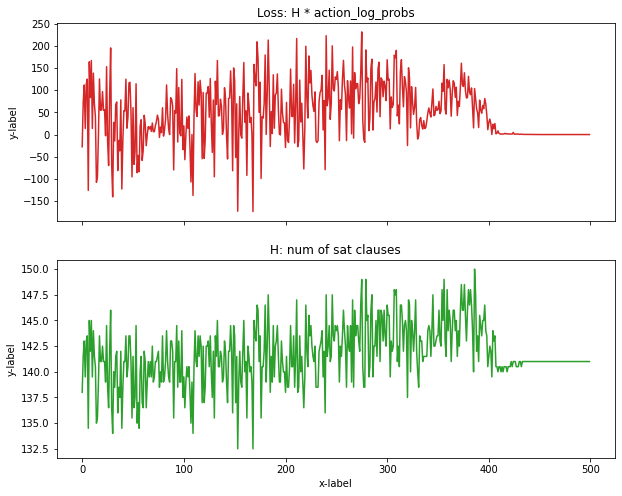

In [51]:
fig, axs = plt.subplots(2, 1,  figsize=(10,8))
axs[0].plot(history_loss, 'tab:red')
axs[0].set_title('Loss: H * action_log_probs')

axs[1].plot(history_H, 'tab:green')
axs[1].set_title('H: num of sat clauses')


for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Experiment 3

Using SATLIB formula

n = 20

r = 4.55

m = (20 * 4.55) = 91

In [21]:
dimacs_path =  'data/uf20-91/uf20-01.cnf'
n, m, formula = utils.dimacs2list(dimacs_path = dimacs_path)

print(f'n: {n}')
print(f'm: {m}')
print(formula)

n: 20
m: 91
[[4, -18, 19], [3, 18, -5], [-5, -8, -15], [-20, 7, -16], [10, -13, -7], [-12, -9, 17], [17, 19, 5], [-16, 9, 15], [11, -5, -14], [18, -10, 13], [-3, 11, 12], [-6, -17, -8], [-18, 14, 1], [-19, -15, 10], [12, 18, -19], [-8, 4, 7], [-8, -9, 4], [7, 17, -15], [12, -7, -14], [-10, -11, 8], [2, -15, -11], [9, 6, 1], [-11, 20, -17], [9, -15, 13], [12, -7, -17], [-18, -2, 20], [20, 12, 4], [19, 11, 14], [-16, 18, -4], [-1, -17, -19], [-13, 15, 10], [-12, -14, -13], [12, -14, -7], [-7, 16, 10], [6, 10, 7], [20, 14, -16], [-19, 17, 11], [-7, 1, -20], [-5, 12, 15], [-4, -9, -13], [12, -11, -7], [-5, 19, -8], [1, 16, 17], [20, -14, -15], [13, -4, 10], [14, 7, 10], [-5, 9, 20], [10, 1, -19], [-16, -15, -1], [16, 3, -11], [-15, -10, 4], [4, -15, -3], [-10, -16, 11], [-8, 12, -5], [14, -6, 12], [1, 6, 11], [-13, -5, -1], [-7, -2, 12], [1, -20, 19], [-2, -13, -8], [15, 18, 4], [-11, 14, 9], [-6, -15, -2], [5, -12, -15], [-6, 17, 5], [-13, 5, -19], [20, -1, 14], [9, -17, 15], [-5, 19, -18

In [22]:
input_size = n #num of variables
embedding_size = 32
hidden_size = 128
output_size = 2 #Two assignments: 0 or 1
num_layers = 1

accumulation_steps = 5
num_episodes = 5000
clip_val = 1

num_rollouts = 2
sampled = True

policy_network = BasicRNN(input_size, embedding_size, hidden_size, output_size, num_layers)

baseline = BaselineRollout(num_rollouts, sampled)

lr = 0.001
optimizer = optim.Adam(policy_network.parameters(), lr=lr)

history_loss, history_H = train.train(accumulation_steps, formula, input_size, num_episodes, policy_network, optimizer, baseline, clip_val)

Episode [5/5000], Loss 27.9303, H 82.0000, Actions [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0], Actions logits [[0.11, -0.05], [0.14, -0.06], [0.12, -0.01], [0.16, -0.07], [0.15, -0.09], [0.15, -0.1], [0.15, -0.11], [0.12, -0.03], [0.11, 0.02], [0.14, -0.06], [0.15, -0.09], [0.11, -0.0], [0.12, -0.04], [0.11, 0.02], [0.11, 0.05], [0.09, 0.04], [0.09, 0.08], [0.08, 0.07], [0.1, -0.02], [0.13, -0.06]]
Episode [10/5000], Loss -22.2993, H 78.4000, Actions [1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0], Actions logits [[0.1, -0.03], [0.09, 0.0], [0.08, -0.02], [0.09, -0.02], [0.05, 0.09], [0.04, 0.05], [0.02, 0.11], [-0.0, 0.14], [0.02, 0.07], [0.02, 0.12], [0.03, 0.06], [0.03, 0.03], [0.01, 0.13], [-0.0, 0.16], [0.03, 0.09], [0.04, 0.02], [0.04, 0.03], [0.03, 0.11], [0.0, 0.15], [-0.01, 0.19]]
Episode [15/5000], Loss -39.6222, H 77.0000, Actions [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0], Actions logits [[0.08, -0.01], [0.05, 0.05], [0.01, 0

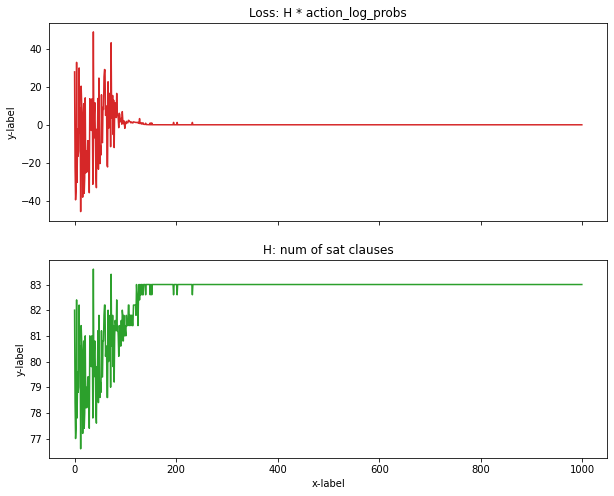

In [23]:
fig, axs = plt.subplots(2, 1,  figsize=(10,8))
axs[0].plot(history_loss, 'tab:red')
axs[0].set_title('Loss: H * action_log_probs')

axs[1].plot(history_H, 'tab:green')
axs[1].set_title('H: num of sat clauses')


for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
is_sat, num_sat, eval_formula = utils.assignment_verifier(formula, assignment)

print(f'assignment: {assignment}')
print(f'assignment sats the formula: {is_sat}')
print(f'num of sat clauses: {num_sat} out of {m}')